## Import

In [2]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../../src/modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline
from sklearn import preprocessing, pipeline, linear_model, impute, model_selection

from typing import Optional, Iterable

# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

### Load all data

In [3]:
# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True)

# google trends
df_trends = eumf_data.load_trends_from_csv()

countries = eumf_data.get_countries()
keyword_ids = df_trends.columns.levels[0].tolist()

df_gdp = eumf_data.read_gdp()
df_unempl = eumf_data.read_unempl()


### Join data, combine countries

In [4]:
country_combinations = [
    ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


10                                                                                                                        11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                 unempl                                                                                                       
country     AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB   GR+CY  HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB    GR+CY    HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB    GR+CY     HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB      GR+CY       HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB    GR+CY      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB  GR+CY    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                    ...                                                                                                                                                                                                                                                                                                                                                                                                              
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381   0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  12.810  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286  29.619  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2399.000  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0   9270.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  17.35  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857   0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   8.286  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  36.476  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2163.000  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  10000.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  16.70  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.4

## Experiments

### Common definitions

In [5]:
T_TEST_MIN = "2014"
T_TEST_MAX = "2014"

cv_default = model_selection.KFold(n_splits=7, shuffle=False)
cv_random = model_selection.KFold(n_splits=7, shuffle=True, random_state=42)

### LinReg - possible feature combinations

In [6]:
### TRAINING

feature_combinations = [
    ["19"],
    ["gdp", "unempl"],
    ["19", "gdp", "unempl"],
    ["value"],
    ["value", "19"],
    ["value", "gdp", "unempl"],
    ["value", "19", "gdp", "unempl"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {
    "linearregression__fit_intercept": [True, False],
    "linearregression__positive": [True, False],
}

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro, columns=features, lags=[1, 2, 3, 4]
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=linear_model.LinearRegression(),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        dummy_encoder="drop",
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [7]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations)


fit_time                       score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod              
                                   mean      std        sem        mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem  
['19']                             0.004   7.848e-04  2.966e-04    0.005    4.118e-04  1.557e-04  -0.082   0.029  0.011   -0.123   0.055  0.021           0.052          0.207  0.078     0.145    0.226  0.085
['gdp', 'unempl']                  0.004   7.130e-04  2.695e-04    0.004    1.458e-04  5.510e-05  -0.095   0.027  0.010   -0.129   0.047  0.018          -0.021          0.206  0.078    -0.004    0.289  0.109
['19', 'gdp', 'unempl']            0.004   7.385e-04  2.791e-04    0.004    1.643e-04  6.212e-05  -0.082   0.022  0.008   -0.117   0.042  0.016           0.076          0.208  0.079     0.158    0.276  0.104
['value']                          0.004   6.666e-04  2.520e-04    0.005    1.070e-03  4.045e-04  -0.060   0.012  0.005   -0.087   0.029  0.011           0.457          0.143  0.054     0.506    0.184  0.069
['value', '19']                    0.004   9.329e-04  3.526e-04    0.005    9.958e-04  3.764e-04  -0.060   0.013  0.005   -0.089   0.030  0.011           0.453          0.127  0.048     0.502    0.172  0.065
['value', 'gdp', 'unempl']         0.006   3.606e-03  1.363e-03    0.006    7.178e-04  2.713e-04  -0.060   0.010  0.004   -0.087   0.026  0.010           0.444          0.169  0.064     0.498    0.206  0.078
['value', '19', 'gdp', 'unempl']   0.005   5.619e-04  2.124e-04    0.006    1.071e-03  4.047e-04  -0.060   0.011  0.004   -0.088   0.028  0.010           0.437          0.151  0.057     0.496    0.192  0.073

In [8]:
eumf_eval.agg_multiple_test_scores(test_scores, feature_combinations)

,mae,rmse,explained_variance,r2_mod
['19'],-0.124,-0.210,0.277,0.249
"['gdp', 'unempl']",-0.133,-0.218,0.112,0.191
"['19', 'gdp', 'unempl']",-0.119,-0.196,0.285,0.349
['value'],-0.082,-0.127,0.694,0.726
"['value', '19']",-0.081,-0.126,0.701,0.733
"['value', 'gdp', 'unempl']",-0.082,-0.123,0.716,0.745
"['value', '19', 'gdp', 'unempl']",-0.082,-0.122,0.718,0.748


#### Performance by year (CV+test)

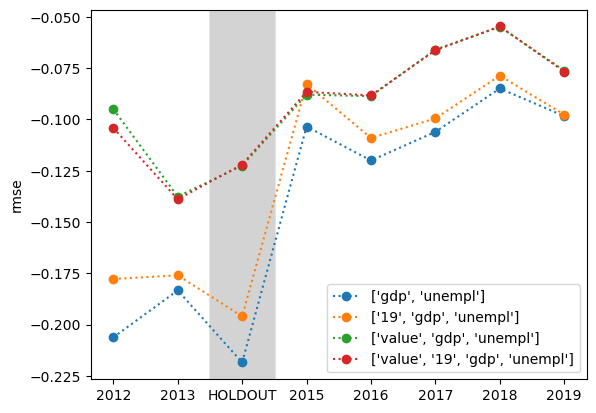

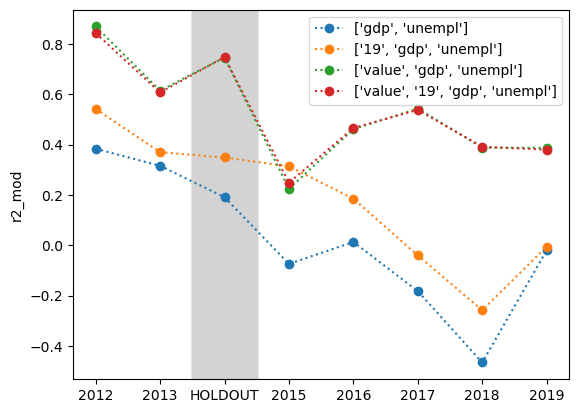

In [9]:
indices = [1, 2, -2, -1]
metrics = ["rmse", "r2_mod"]

fold_labels = [2012, 2013, "HOLDOUT", 2015, 2016, 2017, 2018, 2019]

for m in metrics:
    eumf_eval.cv_performance_plot(
        cv_scores,
        m,
        indices=indices,
        run_labels=feature_combinations,
        fold_labels=fold_labels,
        test_scores=test_scores,
        test_pos=2,
    )
    plt.show()


#### Performance by country

##### without value

In [10]:
i = 2

reg = tuners[i].best_estimator_

test_scores_c = eumf_eval.score_test_countries(reg, test_stackeds[i])
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod
IT,-0.046,-0.052,0.747,0.942
ES,-0.034,-0.035,0.670,0.809
CZ+SK,-0.036,-0.040,0.327,0.776
FR,-0.028,-0.029,0.901,0.629
RO,-0.264,-0.276,0.088,0.423
HR,-0.478,-0.643,0.055,0.383
PL,-0.047,-0.055,0.424,0.329
BG,-0.227,-0.238,-0.177,0.286
HU,-0.062,-0.077,0.526,0.278
LV+LT+EE,-0.092,-0.097,-0.806,0.205


In [11]:
i = 2
reg = tuners[i].best_estimator_

cv_scores_c = eumf_eval.score_cv_countries(reg, train_unstackeds[i], cv_random)
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("r2_mod", "mean"), ascending=False))

CV scores per country:


mae                  rmse                explained_variance                r2_mod              
          mean   std    sem    mean   std    sem          mean          std    sem    mean   std    sem  
IT       -0.045  0.017  0.006 -0.054  0.022  0.008        0.837         0.133  0.050  0.850  0.111  0.042
PT       -0.075  0.017  0.006 -0.088  0.023  0.009        0.417         0.418  0.158  0.657  0.161  0.061
ES       -0.107  0.053  0.020 -0.131  0.051  0.019        0.496         0.141  0.053  0.518  0.135  0.051
HU       -0.080  0.039  0.015 -0.103  0.054  0.021        0.343         0.704  0.266  0.383  0.502  0.190
HR       -0.149  0.118  0.045 -0.203  0.184  0.070        0.317         0.478  0.181  0.367  0.429  0.162
PL       -0.066  0.020  0.008 -0.083  0.024  0.009        0.242         0.575  0.217  0.251  0.325  0.123
RO       -0.089  0.017  0.006 -0.102  0.019  0.007        0.191         0.351  0.133  0.244  0.257  0.097
SI       -0.191  0.108  0.041 -0.225  0.136  0.051        0.320         0.410  0.155  0.161  0.437  0.165
LV+LT+EE -0.076  0.029  0.011 -0.089  0.029  0.011       -0.200         0.650  0.246 -0.249  1.069  0.404
GR+CY    -0.098  0.051  0.019 -0.123  0.062  0.023       -0.113         1.541  0.583 -0.391  1.722  0.651
IE       -0.083  0.020  0.008 -0.100  0.022  0.008       -2.653         5.221  1.973 -0.593  0.937  0.354
CZ+SK    -0.065  0.020  0.007 -0.082  0.042  0.016        0.034         1.575  0.595 -0.778  2.402  0.908
BG       -0.063  0.013  0.005 -0.076  0.017  0.007       -2.346         4.279  1.617 -0.883  1.366  0.516
BE+NL+LU -0.044  0.018  0.007 -0.054  0.027  0.010       -1.013         2.592  0.980 -1.128  2.853  1.078
GB       -0.074  0.031  0.012 -0.089  0.038  0.014       -4.410         5.188  1.961 -1.499  1.964  0.742
SE+FI+DK -0.049  0.013  0.005 -0.059  0.017  0.006       -0.721         1.579  0.597 -1.904  2.512  0.950
FR       -0.051  0.018  0.007 -0.063  0.017  0.006       -2.310         6.076  2.296 -3.513  7.153  2.704
AT+CH    -0.085  0.051  0.019 -0.109  0.055  0.021       -4.321        11.047  4.175 -4.818  9.832  3.716

##### with value

In [12]:
i = -1

reg = tuners[i].best_estimator_

test_scores_c = eumf_eval.score_test_countries(reg, test_stackeds[i])
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod
LV+LT+EE,-0.025,-0.030,0.100,0.924
IT,-0.055,-0.061,0.092,0.918
HR,-0.286,-0.334,0.455,0.834
ES,-0.034,-0.035,0.671,0.809
CZ+SK,-0.030,-0.038,0.308,0.803
FR,-0.018,-0.024,-0.022,0.746
RO,-0.154,-0.189,-2.828,0.729
HU,-0.045,-0.051,0.675,0.684
BG,-0.138,-0.176,-3.771,0.610
PT,-0.129,-0.148,-1.038,0.557


In [13]:
i = -1
reg = tuners[i].best_estimator_

cv_scores_c = eumf_eval.score_cv_countries(reg, train_unstackeds[i], cv_random)
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("r2_mod", "mean"), ascending=False))

CV scores per country:


mae                  rmse                explained_variance               r2_mod              
          mean   std    sem    mean   std    sem          mean         std    sem    mean   std    sem  
IT       -0.035  0.019  0.007 -0.040  0.018  0.007        0.852        0.238  0.090  0.878  0.167  0.063
ES       -0.061  0.023  0.009 -0.071  0.027  0.010        0.689        0.531  0.201  0.758  0.372  0.141
HU       -0.061  0.024  0.009 -0.071  0.027  0.010        0.673        0.381  0.144  0.729  0.195  0.074
RO       -0.057  0.019  0.007 -0.068  0.023  0.009        0.593        0.258  0.098  0.649  0.189  0.071
SI       -0.103  0.047  0.018 -0.124  0.055  0.021        0.696        0.239  0.090  0.641  0.327  0.124
HR       -0.122  0.123  0.047 -0.158  0.167  0.063        0.533        0.394  0.149  0.602  0.323  0.122
PT       -0.079  0.018  0.007 -0.090  0.021  0.008        0.056        1.312  0.496  0.523  0.424  0.160
PL       -0.057  0.036  0.013 -0.071  0.045  0.017        0.260        0.875  0.331  0.389  0.547  0.207
LV+LT+EE -0.042  0.018  0.007 -0.057  0.031  0.012        0.147        1.188  0.449  0.180  1.476  0.558
BG       -0.047  0.024  0.009 -0.053  0.025  0.009       -1.145        2.983  1.127  0.114  0.842  0.318
CZ+SK    -0.058  0.042  0.016 -0.070  0.054  0.020       -0.036        1.491  0.564  0.109  0.747  0.282
GR+CY    -0.072  0.027  0.010 -0.087  0.036  0.014        0.208        1.220  0.461  0.056  1.394  0.527
IE       -0.075  0.018  0.007 -0.087  0.022  0.008       -1.403        2.555  0.966 -0.181  0.743  0.281
BE+NL+LU -0.037  0.012  0.005 -0.044  0.018  0.007       -0.410        1.835  0.694 -0.344  1.813  0.685
AT+CH    -0.058  0.035  0.013 -0.075  0.048  0.018       -0.122        0.735  0.278 -0.423  1.122  0.424
SE+FI+DK -0.037  0.020  0.007 -0.042  0.021  0.008       -0.756        2.924  1.105 -0.756  2.969  1.122
FR       -0.042  0.017  0.007 -0.050  0.018  0.007       -0.996        2.485  0.939 -1.638  4.141  1.565
GB       -0.053  0.027  0.010 -0.066  0.040  0.015       -3.289        5.968  2.256 -2.425  6.818  2.577

##### diff KW19 vs no KW19 (without value)


In [14]:
i1, i2 = 2, 1
reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_random)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0, use_quantiles=False)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_random)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0, use_quantiles=False)

cv_diff = cv_scores_c_agg1.xs("mean", level=1, axis=1) - cv_scores_c_agg2.xs(
    "mean", level=1, axis=1
)

cv_diff["rmse"].round(3).sort_values(ascending=False)



IT          0.049
HU          0.034
GR+CY       0.028
PT          0.022
BG          0.015
CZ+SK       0.014
BE+NL+LU    0.013
PL          0.013
ES          0.012
AT+CH       0.009
FR          0.009
HR          0.007
SE+FI+DK    0.004
LV+LT+EE    0.003
IE         -0.001
GB         -0.002
RO         -0.007
SI         -0.033
Name: rmse, dtype: float64

##### diff KW19 vs no KW19 (with value)


In [15]:
i1, i2 = -1, -2
reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_random)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0, use_quantiles=False)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_random)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0, use_quantiles=False)

cv_diff = cv_scores_c_agg1.xs("mean", level=1, axis=1) - cv_scores_c_agg2.xs(
    "mean", level=1, axis=1
)

cv_diff["rmse"].round(3).sort_values(ascending=False)

IT          0.005
AT+CH       0.001
CZ+SK       0.001
GR+CY      -0.000
PL         -0.000
IE         -0.000
HU          0.000
ES          0.000
HR         -0.001
FR         -0.001
BG         -0.001
SE+FI+DK   -0.001
GB         -0.002
BE+NL+LU   -0.002
LV+LT+EE   -0.002
PT         -0.002
RO         -0.002
SI         -0.017
Name: rmse, dtype: float64

#### coefficients (standardized)

In [16]:
reg = tuners[2].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
pd.Series(reg.steps[-1][1].coef_, index=features_names_out).sort_values(
    ascending=False
)

19_1        0.033
unempl_4    0.027
19_2        0.027
unempl_2    0.025
unempl_1    0.019
gdp_3       0.018
19_3        0.011
19_4        0.000
gdp_1       0.000
gdp_2       0.000
gdp_4       0.000
unempl_3    0.000
dtype: float64

#### Plot prediction (all features)

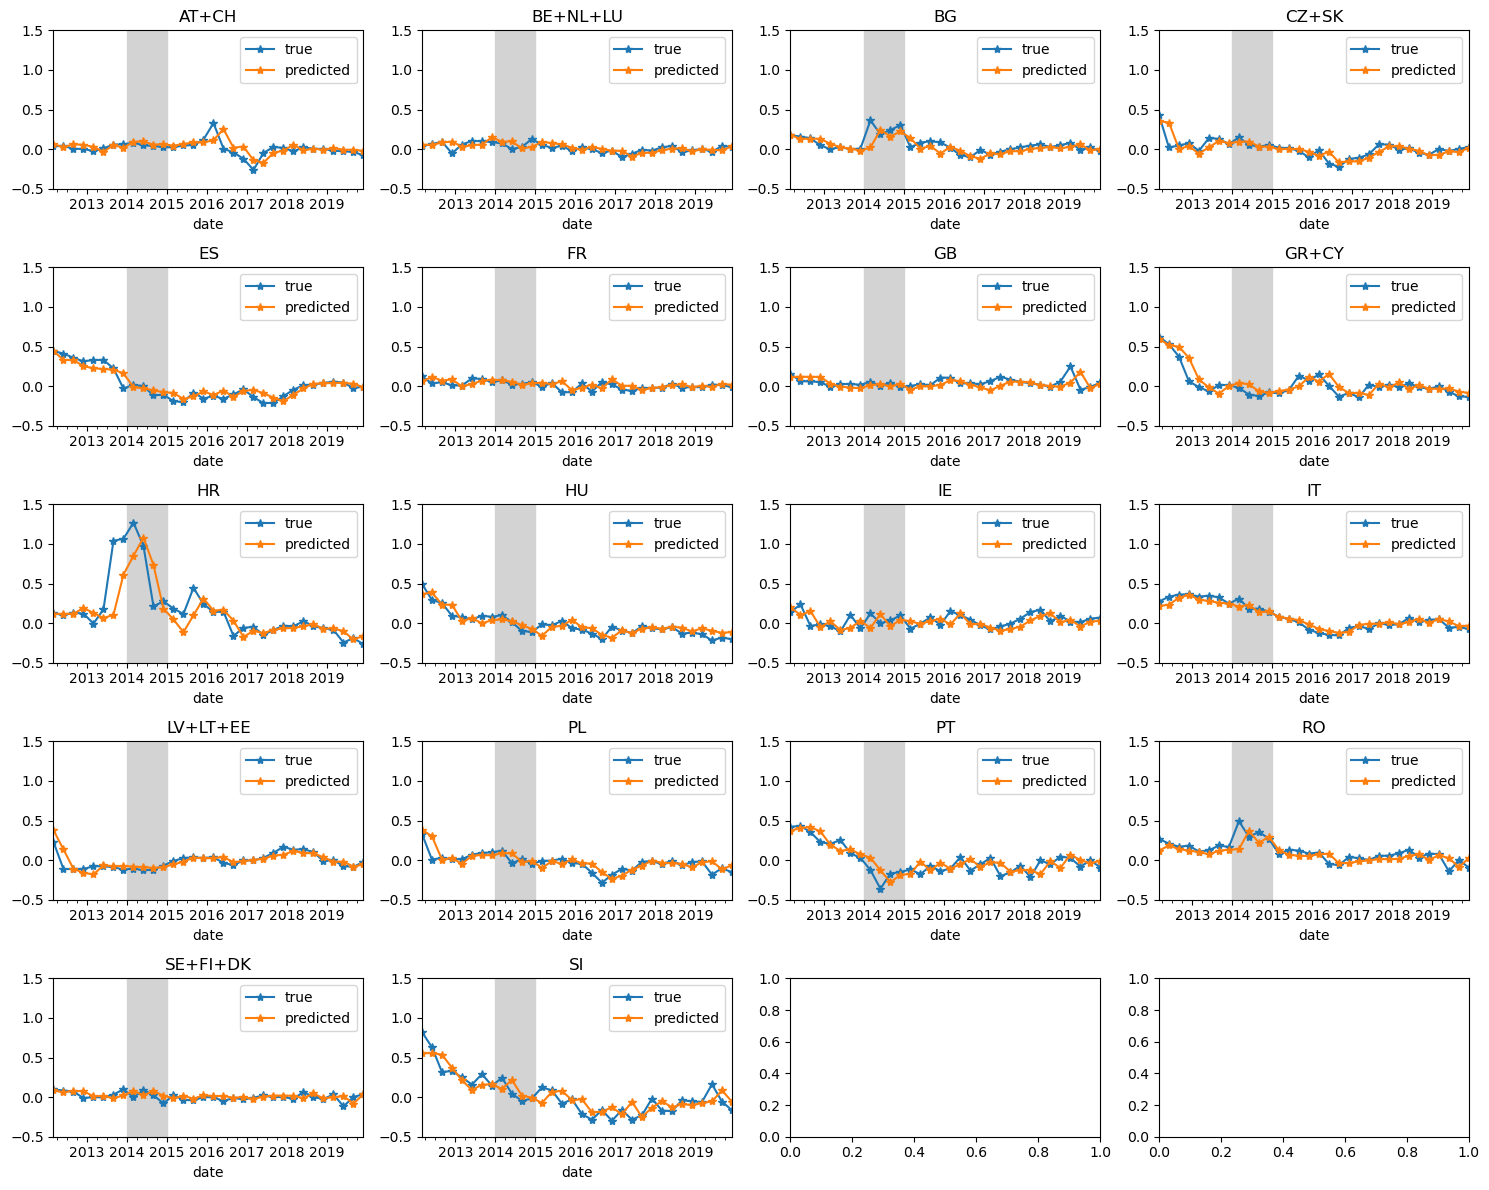

In [17]:
i = -1
reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="*",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()


#### Plot prediction (without own lags)

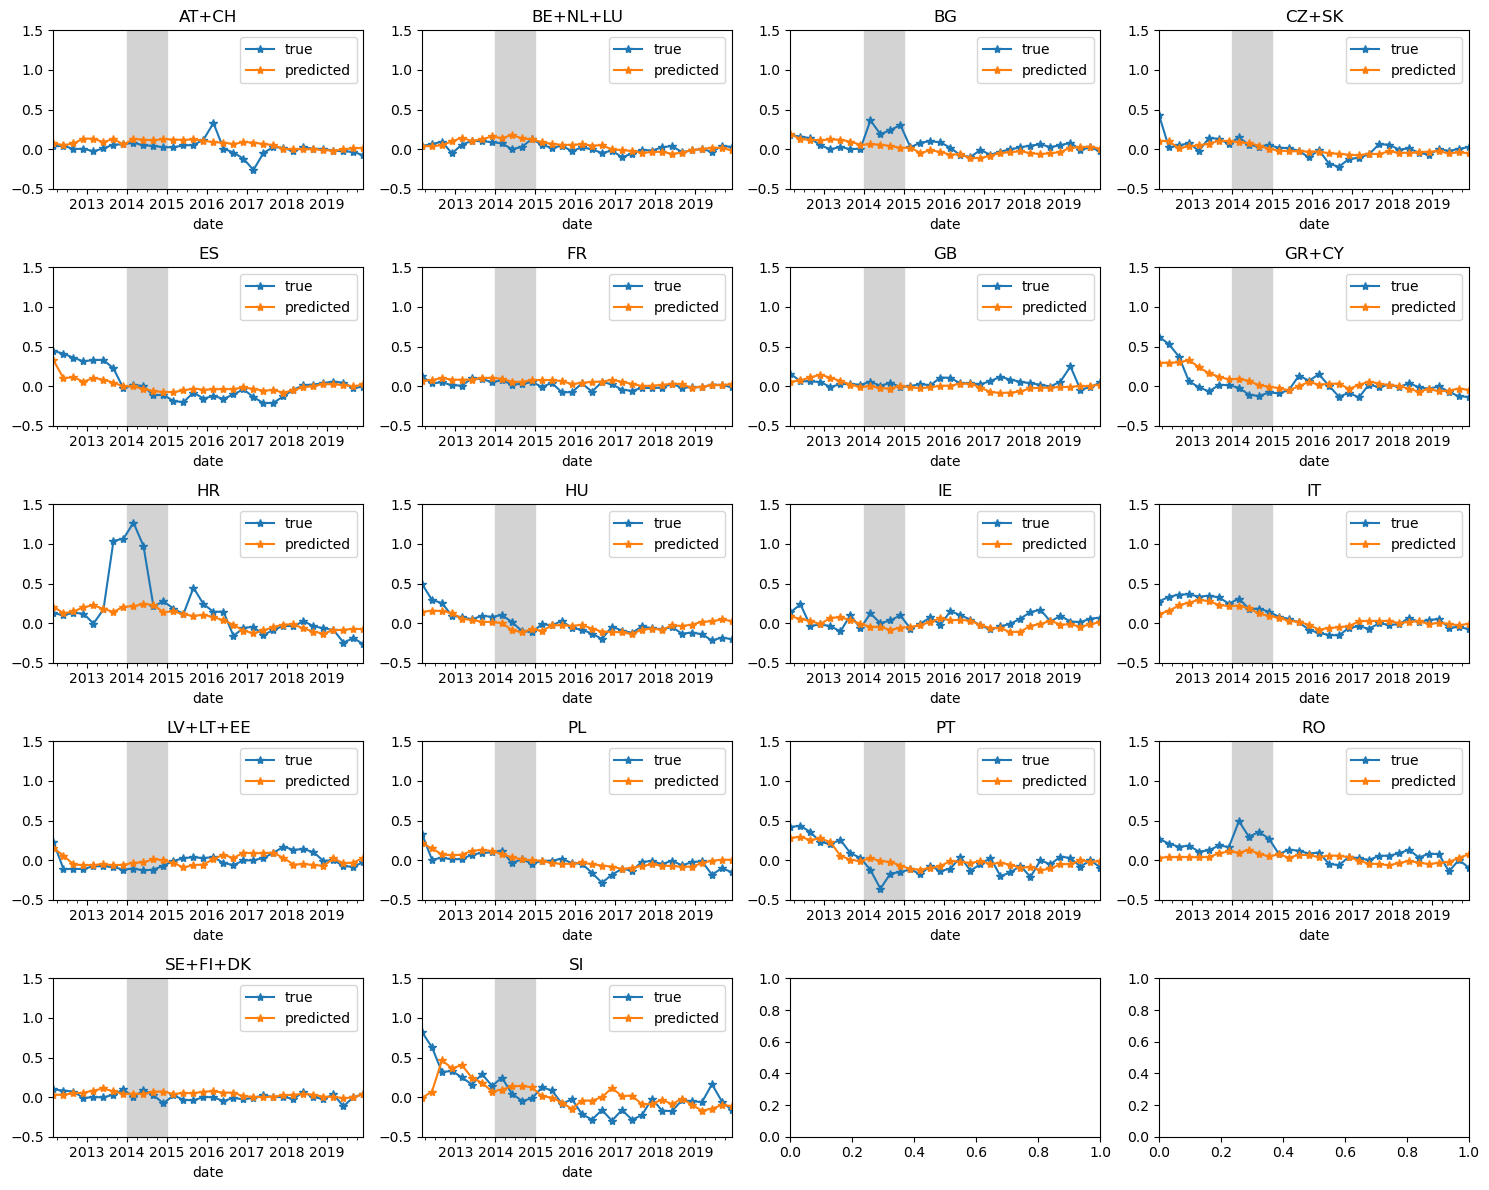

In [18]:
i = 2

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="*",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()

### monthly frequency with 3m rolling mean

In [20]:
### TRAINING

feature_combinations = [
    ["19"],
    ["value"],
    ["value", "19"],
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds = [], []

params = {
    "linearregression__fit_intercept": [True, False],
    "linearregression__positive": [True, False],
}

panel_resampled = panel_comb.rolling("90D").mean()

for features in feature_combinations:

    labeled = eumf_pipeline.prepare_data(
        panel_resampled, columns=features, lags=[3, 6, 9, 12]
    )
    transformed = eumf_pipeline.transform_data(labeled, delta=12)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
    train_stackeds.append(train_stacked)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=linear_model.LinearRegression(),
        extra_pipeline_steps=[preprocessing.StandardScaler()],
        dummy_encoder="drop",
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [21]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations)


fit_time                       score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod              
                  mean      std        sem        mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem  
['19']            0.002   2.661e-04  1.006e-04    0.003    7.440e-04  2.812e-04  -0.085   0.033  0.012   -0.125   0.059  0.022           0.042          0.254  0.096     0.129    0.285  0.108
['value']         0.002   5.184e-04  1.959e-04    0.003    7.601e-04  2.873e-04  -0.062   0.016  0.006   -0.088   0.030  0.011           0.465          0.119  0.045     0.516    0.168  0.063
['value', '19']   0.003   2.966e-04  1.121e-04    0.003    7.780e-04  2.941e-04  -0.062   0.015  0.006   -0.088   0.030  0.011           0.472          0.105  0.040     0.524    0.159  0.060

In [22]:
eumf_eval.agg_multiple_test_scores(test_scores, feature_combinations)

,mae,rmse,explained_variance,r2_mod
['19'],-0.125,-0.211,0.308,0.260
['value'],-0.073,-0.112,0.762,0.791
"['value', '19']",-0.072,-0.110,0.772,0.800


### All Keywords

#### all features

In [24]:
params = (
    {
        "elasticnet__alpha": [1.0, 0.2, 0.1, 0.5, 0.01],
        "elasticnet__l1_ratio": [0.4, 0.45, 0.5, 0.55, 0.6],
        "elasticnet__fit_intercept": [True, False],
        "elasticnet__positive": [True, False],
    },
)

labeled = eumf_pipeline.prepare_data(panel_comb_3m_macro, lags=[1, 2, 3, 4])
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

tuner = eumf_pipeline.train_reg_model(
    train_stacked,
    reg=linear_model.ElasticNet(),
    extra_pipeline_steps=[preprocessing.StandardScaler()],
    dummy_encoder="drop",
    params=params,
    scoring=eumf_eval.scorer_rmse,
)

cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)

test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked)


In [25]:
eumf_eval.agg_cv_scores(cv_score)

,mean,std,sem
fit_time,0.010,1.277e-03,4.827e-04
score_time,0.007,8.218e-04,3.106e-04
test_mae,-0.061,1.122e-02,4.239e-03
test_rmse,-0.090,2.972e-02,1.123e-02
test_explained_variance,0.418,1.306e-01,4.936e-02
test_r2_mod,0.482,1.747e-01,6.602e-02


In [26]:
test_score

mae                  -0.081
rmse                 -0.127
explained_variance    0.694
r2_mod                0.725
dtype: float64

##### non-zero coefficients

In [27]:
reg = tuner.best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
coefs = pd.Series(reg.steps[-1][1].coef_, index=features_names_out).sort_values(
    ascending=False
)
coefs[coefs > 0.0]



value_1     1.048e-01
unempl_1    8.961e-03
21_1        7.873e-03
28_2        5.562e-03
unempl_2    4.367e-03
48_2        3.197e-03
19_1        2.352e-03
26_2        2.169e-03
115_3       2.013e-03
24_1        1.684e-03
unempl_4    1.088e-03
21_3        1.051e-03
59_1        9.253e-04
58_2        8.861e-04
21_4        6.115e-04
54_1        6.015e-04
115_2       8.972e-05
dtype: float64

#### all except own lag

In [29]:
params = (
    {
        "elasticnet__alpha": [1.0, 0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01],
        "elasticnet__l1_ratio": [0.35, 0.38, 0.4, 0.42, 0.45, 0.5, 0.55, 0.6],
        "elasticnet__fit_intercept": [True, False],
        "elasticnet__positive": [True, False],
    },
)

columns = [
    c for c in panel_comb_3m_macro.columns.get_level_values(0).unique() if c != "value"
]

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro, lags=[1, 2, 3, 4], columns=columns
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

tuner = eumf_pipeline.train_reg_model(
    train_stacked,
    reg=linear_model.ElasticNet(),
    extra_pipeline_steps=[preprocessing.StandardScaler()],
    dummy_encoder="drop",
    params=params,
    scoring=eumf_eval.scorer_rmse,
)

cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)

test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked)

tuner.best_params_


{'elasticnet__alpha': 0.03,
 'elasticnet__fit_intercept': False,
 'elasticnet__l1_ratio': 0.4,
 'elasticnet__positive': True}

In [30]:
eumf_eval.agg_cv_scores(cv_score)

,mean,std,sem
fit_time,0.011,6.452e-04,2.439e-04
score_time,0.007,8.596e-04,3.249e-04
test_mae,-0.084,2.331e-02,8.812e-03
test_rmse,-0.122,4.870e-02,1.841e-02
test_explained_variance,0.066,1.453e-01,5.491e-02
test_r2_mod,0.092,3.739e-01,1.413e-01


In [31]:
test_score

mae                  -0.119
rmse                 -0.208
explained_variance    0.237
r2_mod                0.269
dtype: float64

##### non-zero coefficients

In [32]:
reg = tuner.best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
coefs = pd.Series(reg.steps[-1][1].coef_, index=features_names_out).sort_values(
    ascending=False
)
coefs[coefs > 0.0]



19_1        0.028
unempl_2    0.019
unempl_1    0.016
19_2        0.015
unempl_4    0.013
28_3        0.007
28_4        0.006
24_1        0.005
unempl_3    0.005
28_2        0.004
19_3        0.004
dtype: float64